# Case Study

The desired solution is a proof of concept, where we extract transcripts from audio files. Then we extract From the generated text as much as we can named entities: locations, numbers, etc.

For data, we have a zip file with 55 audio files of 1 minute duration. For the 10 first, there's ground truth Danish transcripts.



# Install Packages

In [ ]:
## Install dependencies

!pip install wget
!apt-get install sox libsndfile1 ffmpeg
!pip install unidecode
!pip install matplotlib>=3.3.2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Reading package lists... Done
Building dependency tree       
Reading state information... Done
libsndfile1 is already the newest version (1.0.28-4ubuntu0.18.04.2).
ffmpeg is already the newest version (7:3.4.11-0ubuntu0.1).
sox is already the newest version (14.4.2-3ubuntu0.18.04.1).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 20 not upgraded.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
## Install NeMo
# NeMo's ASR collection - this collections contains complete ASR models and
# building blocks (modules) for ASR

BRANCH = 'main'
!python -m pip install git+https://github.com/NVIDIA/NeMo.git@$BRANCH#egg=nemo_toolkit[all]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/NVIDIA/NeMo.git (to revision main) to /tmp/pip-install-w1b3nt07/nemo-toolkit_99a7b66c834641d1b2357e732b3b5338
  Running command git clone -q https://github.com/NVIDIA/NeMo.git /tmp/pip-install-w1b3nt07/nemo-toolkit_99a7b66c834641d1b2357e732b3b5338
  Using cached matplotlib-3.5.3-cp37-cp37m-manylinux_2_5_x86_64.manylinux1_x86_64.whl (11.2 MB)


In [ ]:
## Install DanNLP
# DanNLP module for pre-trained language model for Danish

!pip install danlp 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 82 kB 1.1 MB/s 
  Created wheel for progressbar: filename=progressbar-2.5-py3-none-any.whl size=12082 sha256=25c2a908cc5213443e2e8bfa0d39d80ebea017d4c91c85ea2a788685b3e6cf1a
  Stored in directory: /root/.cache/pip/wheels/f0/fd/1f/3e35ed57e94cd8ced38dd46771f1f0f94f65fec548659ed855
Successfully built progressbar


In [ ]:
## Import packages

import librosa
import IPython.display as ipd

%matplotlib inline
import librosa.display
import matplotlib.pyplot as plt
import numpy as np

from collections import defaultdict

import json
import glob, os
import re

import nemo
import nemo.collections.asr as nemo_asr

from omegaconf import DictConfig
import copy
import pytorch_lightning as pl

from danlp.models import load_bert_ner_model

[NeMo W 2022-09-03 14:18:46 optimizers:55] Apex was not found. Using the lamb or fused_adam optimizer will error out.


# Data Exploration: Audio

Data exploration is the initial step where we use data visualization and statistical techniques to describe dataset characterizations, such as size, quantity, and accuracy, in order to better understand the nature of the data.Let's start by loading and taking a look at a sample data. We take here the example file RADIO_YYY_1642200720.wav which is a 60 second-long audio recording of a women speaking in Danish. To confirm this, we can listen to the file:

In [ ]:
# Load and listen to the audio file
example_file = "/content/RADIO_YYY_1642200720.wav"
audio, sample_rate = librosa.load(example_file)

print(f"The sample rate of the audio is {sample_rate} Hz")
print("Click below to hear it: ")

ipd.Audio(example_file, rate=sample_rate)

The sample rate of the audio is 22050 Hz
Click below to hear it: 


Let's then plot the waveform, which is simply a line plot of the sequence of values that we read from the file: The amplitude with respect to the time.

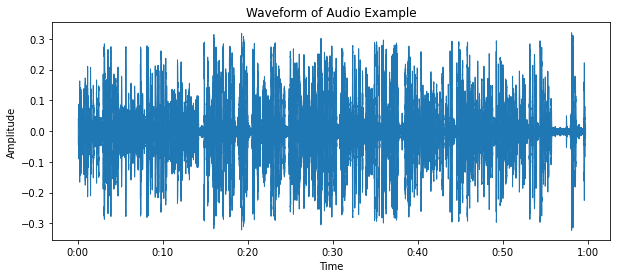

In [ ]:
# Plot the example audio file's waveform
plt.rcParams['figure.figsize'] = (10,4)
plt.title('Waveform of Audio Example')
plt.ylabel('Amplitude')

_ = librosa.display.waveshow(audio)

We can apply a Fourier Transform on our audio signal to get something more useful: a spectrogram, which is a representation of the energy levels (i.e. amplitude, or "loudness") of each frequency (i.e. pitch) of the signal over the duration of the file. It is a good way of seeing how the strengths of various frequencies in the audio vary over time.

Let's examine what the spectrogram of our sample looks like.

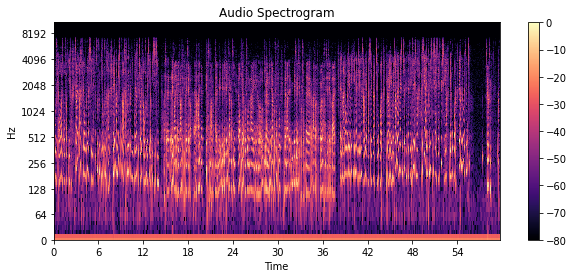

In [ ]:
# Get spectrogram using Librosa's Short-Time Fourier Transform (stft)
spec = np.abs(librosa.stft(audio))
spec_db = librosa.amplitude_to_db(spec, ref=np.max)  # Decibels

# Use log scale to view frequencies
librosa.display.specshow(spec_db, y_axis='log', x_axis='time')
plt.colorbar()
plt.title('Audio Spectrogram');

It is better to have a look at the mel spectrogram because in this case we are processing and transcribing human speech. Mel spectrogram is a transformation of the frequencies to be more aligned to what humans perceive.

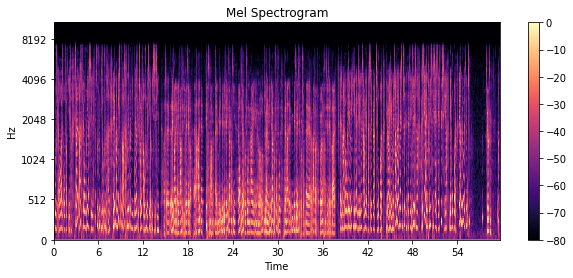

In [ ]:
# Plot the mel spectrogram of our sample
mel_spec = librosa.feature.melspectrogram(audio, sr=sample_rate)
mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)

librosa.display.specshow(
    mel_spec_db, x_axis='time', y_axis='mel')
plt.colorbar()
plt.title('Mel Spectrogram');

# Data Exploration: Text

We continu with exploring the text data (The transcripst). Here, we identify relationships between different charaters/words, the structure of the dataset, the presence of outliers, and the distribution of data values in order to reveal patterns and points of interest, enabling data analysts to gain greater insight into the raw data.

In [ ]:
# Have a look at the transcripts

with open("/content/text.txt") as f:
    text = f.read()
print(text[:1000])

hvis niveauet skal overholdes over for de ældre det samlede arbejdskraftbehov vurderes til 90000 i 2030 men hvem har mest brug for arbejdskraften det spurgte vi professor filip schrøder fra aarhus universitet om i sidste time
at rigtig meget af det der bliver fremstillet i privatsektor har lidt mere tilpasningsmargener lidt forenklet sagt kan man sige offentlig sektorproduktion har jo en en undskyld terminologien men det har jo en produktionsmetode hvor der er meget menneske menneske produktion alt fra fra fra børnepasning til til ældrepleje
ja altså med andre ord det vil nok ikke give genvalg hvis vælgerne skal aflevere deres børn til robotter i børnehaven men spørgsmålet er om dansk industri danske industrivirksomheder accepterer den præmis at de skal erstatte fysiske hænder med robotter velkommen nu Steen Olsen
Steen Nielsen
nå
fået noget forkert at vide det må du i hvert fald undskylde steen nielsen vicedirektør i dansk industri med arbejdsmarked som fokusområde
steen nielsen samle

In [ ]:
# Create a corpus of Danish text 
corpus=[word for word in text.split()]

dic_words=defaultdict(int)
for word in corpus:
    dic_words[word]+=1

<BarContainer object of 20 artists>

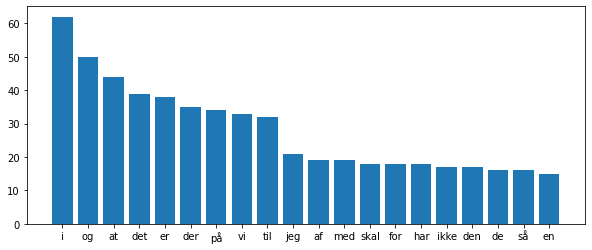

In [ ]:
# Identify the most frequent words
top=sorted(dic_words.items(), key=lambda x:x[1],reverse=True)[:20] 
x,y=zip(*top)
plt.bar(x,y)

In [ ]:
# Create the Danish vocabulary
vocabulary=[char for char in text]

dic_vocab=defaultdict(int)
for char in vocabulary:
    dic_vocab[char]+=1

<BarContainer object of 20 artists>

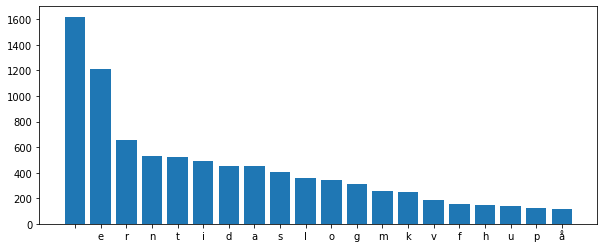

In [ ]:
# Identify the most frequent characters
vocabulary=sorted(dic_vocab.items(), key=lambda x:x[1],reverse=True)
top = vocabulary[:20]
x,y=zip(*top)
plt.bar(x,y)

In [ ]:
# Define the length of the Danish vocabulary
voc, fre=zip(*vocabulary)
print(f"We have {len(voc)} unique characters in the danich vocaluary: \n {voc}")

We have 58 unique characters in the danich vocaluary: 
 (' ', 'e', 'r', 'n', 't', 'i', 'd', 'a', 's', 'l', 'o', 'g', 'm', 'k', 'v', 'f', 'h', 'u', 'p', 'å', 'b', 'j', 'æ', 'ø', '\n', 'c', 'y', '0', 'S', 'D', 'A', 'N', 'F', '3', 'H', '5', 'M', 'J', '9', '%', 'w', 'V', 'I', 'L', '2', 'O', '4', '1', '6', 'C', 'E', 'T', 'K', 'P', 'W', 'B', 'z', 'G')


# Data Preprocessing:

Based on the data exploration, we clean the data to put it in a format where the acoustique model will be able to use it.

In [ ]:
# --- Building Manifest Files --- #

# Build the manifest file which contains the metadata
# audio_path, its duration and the transcript

data_dir = "/content/"

def build_manifest(data_dir, manifest_path):

    with open(manifest_path, 'w', encoding='utf-8') as fout:
      for transcript_file in glob.glob("*.txt"):
        with open(data_dir+transcript_file, encoding='utf-8') as f:
          transcript = f.read()
          transcript = transcript.lower()
          transcript = re.sub(r'[^\w\s]', '', transcript)
          audio_path = data_dir + transcript_file.replace(".txt", ".wav")
          duration = librosa.core.get_duration(filename=audio_path)
          # Write the metadata to the manifest
          metadata = {
              "audio_filepath": audio_path,
              "duration": duration,
              "text": transcript
          }
          json.dump(metadata, fout)
          fout.write('\n')
                  
# Building Manifests
print("******")
train_manifest = data_dir + "train_manifest.json"
if not os.path.isfile(train_manifest):
    build_manifest(data_dir, train_manifest)
    print("Training manifest created.")
print("***Done***")

******
***Done***


# Acoustique Modelling

The QuartzNet is better variant of Jasper with a key difference that it uses time-channel separable 1D convolutions. The model is composed of multiple blocks with residual connections between them, trained with CTC loss. Each block consists of one or more modules with 1D time-channel separable convolutional layers, batch normalization, and ReLU layers. This allows it to dramatically reduce number of weights while keeping similar accuracy. 

Here, wer use QuartzNet15x5 Encoder and Decoder neural module's checkpoints available here are trained using Neural Modules toolkit. These modules were trained on English data using LibriSpeech (+-10% speed perturbation) and Mozilla's EN Common Voice "validated" set. This model achievs 4.19% WER on LibriSpeech test-clean and 10.98% on test-other without any language models, using greedy decoder.

In [ ]:
# This line will download pre-trained QuartzNet15x5 model from NVIDIA's
# NGC cloud and instantiate it. The modèle was trained on large amount of
# English recordings
quartznet = nemo_asr.models.EncDecCTCModel.from_pretrained(model_name="QuartzNet15x5Base-En")

[NeMo I 2022-09-03 14:30:04 cloud:66] Downloading from: https://api.ngc.nvidia.com/v2/models/nvidia/nemospeechmodels/versions/1.0.0a5/files/QuartzNet15x5Base-En.nemo to /root/.cache/torch/NeMo/NeMo_1.12.0rc0/QuartzNet15x5Base-En/2b066be39e9294d7100fb176ec817722/QuartzNet15x5Base-En.nemo
[NeMo I 2022-09-03 14:30:23 common:910] Instantiating model from pre-trained checkpoint
[NeMo I 2022-09-03 14:30:25 features:223] PADDING: 16
[NeMo I 2022-09-03 14:30:27 audio_preprocessing:491] Numba CUDA SpecAugment kernel is being used
[NeMo I 2022-09-03 14:30:33 save_restore_connector:243] Model EncDecCTCModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.12.0rc0/QuartzNet15x5Base-En/2b066be39e9294d7100fb176ec817722/QuartzNet15x5Base-En.nemo.


In [ ]:
# Check the model's config information
# Number of layers, vocabulary, optimization params...

try:
    from ruamel.yaml import YAML
except ModuleNotFoundError:
    from ruamel_yaml import YAML
config_path = './configs/config.yaml'

if not os.path.exists(config_path):
    # Grab the config we'll use in this example
    BRANCH = 'main'
    !mkdir configs
    !wget -P configs/ https://raw.githubusercontent.com/NVIDIA/NeMo/$BRANCH/examples/asr/conf/config.yaml

yaml = YAML(typ='safe')
with open(config_path) as f:
    params = yaml.load(f)
print(params)

--2022-09-03 14:35:10--  https://raw.githubusercontent.com/NVIDIA/NeMo/main/examples/asr/conf/config.yaml
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4280 (4.2K) [text/plain]
Saving to: ‘configs/config.yaml’

config.yaml         100%[===================>]   4.18K  --.-KB/s    in 0s      

2022-09-03 14:35:11 (67.7 MB/s) - ‘configs/config.yaml’ saved [4280/4280]

{'name': 'QuartzNet15x5', 'sample_rate': 16000, 'repeat': 1, 'dropout': 0.0, 'separable': True, 'labels': [' ', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', "'"], 'model': {'train_ds': {'manifest_filepath': '???', 'sample_rate': 16000, 'labels': [' ', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm

Transfer learning is an important machine learning technique that uses a model’s knowledge of one task to make it perform better on another. Fine-tuning is one of the techniques to perform transfer learning. It is an essential part of the recipe for many state-of-the-art results where a base model is first pretrained on a language with abundant training data (English for example) and then fine-tuned on different language of interest where the training data is less abundant or even scarce (Danish for example).

Transfer learning with NeMo is simple. We need to freeze the encoder layer from the pretrained model. Then, use its decoder after changing the vocabulary to train it on the Danish dataset over multiple epochs. It is necessary to change few other parameters such as the learning rate (devide it by 10 for better results)

In [ ]:
# Check what kind of vocabulary/alphabet the model has right now
print(quartznet.decoder.vocabulary)

# entirely when fine-tuning using a different language.
quartznet.change_vocabulary(
    new_vocabulary=[
        'e', 'r', 'n', 't', 'i', 'd', 'a', 's', 'l', 'o',
        'g', 'm', 'k', 'v', 'f', 'h', 'u', 'p', 'å', 'b', 
        'j', 'æ', 'ø', 'c', 'y', 'w', 'z', ' '
    ]
)

[NeMo W 2022-09-03 14:38:02 ctc_models:244] Old ['e', 'r', 'n', 't', 'i', 'd', 'a', 's', 'l', 'o', 'g', 'm', 'k', 'v', 'f', 'h', 'u', 'p', 'å', 'b', 'j', 'æ', 'ø', 'c', 'y', 'w', 'z', ' '] and new ['e', 'r', 'n', 't', 'i', 'd', 'a', 's', 'l', 'o', 'g', 'm', 'k', 'v', 'f', 'h', 'u', 'p', 'å', 'b', 'j', 'æ', 'ø', 'c', 'y', 'w', 'z', ' '] match. Not changing anything.


['e', 'r', 'n', 't', 'i', 'd', 'a', 's', 'l', 'o', 'g', 'm', 'k', 'v', 'f', 'h', 'u', 'p', 'å', 'b', 'j', 'æ', 'ø', 'c', 'y', 'w', 'z', ' ']


In [ ]:
# Update parameters for the transfer learning

new_opt = copy.deepcopy(params['model']['optim'])
new_opt['lr'] = 0.001
params['model']['train_ds']['manifest_filepath'] = data_dir + "train_manifest.json"
params['model']['validation_ds']['manifest_filepath'] = data_dir + "train_manifest.json"

params['model']['train_ds']["batch_size"] = 2
params['model']['validation_ds']["batch_size"] = 2

params['model']['train_ds']["max_duration"] = 60
params['model']['validation_ds']["max_duration"] = 60

In [ ]:
# Make sure to use the smaller learning rate we set before
quartznet.setup_optimization(optim_config=DictConfig(new_opt))

# Point to the data we'll use for fine-tuning as the training set
quartznet.setup_training_data(train_data_config=params['model']['train_ds'])

# Point to the new validation data for fine-tuning
quartznet.setup_validation_data(val_data_config=params['model']['train_ds'])

# And now we can create a PyTorch Lightning trainer and call `fit` again.
trainer = pl.Trainer(devices=1, accelerator='gpu', max_epochs=2)
trainer.fit(quartznet)

[NeMo W 2022-09-03 14:39:46 modelPT:486] Trainer wasn't specified in model constructor. Make sure that you really wanted it.


[NeMo I 2022-09-03 14:39:46 modelPT:597] Optimizer config = Novograd (
    Parameter Group 0
        amsgrad: False
        betas: [0.8, 0.5]
        eps: 1e-08
        grad_averaging: False
        lr: 0.001
        weight_decay: 0.001
    )


[NeMo W 2022-09-03 14:39:46 lr_scheduler:891] Neither `max_steps` nor `iters_per_batch` were provided to `optim.sched`, cannot compute effective `max_steps` !
    Scheduler will not be instantiated !


[NeMo I 2022-09-03 14:39:46 audio_to_text_dataset:42] Model level config does not contain `sample_rate`, please explicitly provide `sample_rate` to the dataloaders.
[NeMo I 2022-09-03 14:39:46 audio_to_text_dataset:42] Model level config does not contain `labels`, please explicitly provide `labels` to the dataloaders.
[NeMo I 2022-09-03 14:39:46 collections:194] Dataset loaded with 3 files totalling 0.05 hours
[NeMo I 2022-09-03 14:39:46 collections:195] 0 files were filtered totalling 0.00 hours


[NeMo W 2022-09-03 14:39:46 nemo_logging:349] /usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
      cpuset_checked))
    


[NeMo I 2022-09-03 14:39:46 audio_to_text_dataset:42] Model level config does not contain `sample_rate`, please explicitly provide `sample_rate` to the dataloaders.
[NeMo I 2022-09-03 14:39:46 audio_to_text_dataset:42] Model level config does not contain `labels`, please explicitly provide `labels` to the dataloaders.
[NeMo I 2022-09-03 14:39:46 collections:194] Dataset loaded with 3 files totalling 0.05 hours
[NeMo I 2022-09-03 14:39:46 collections:195] 0 files were filtered totalling 0.00 hours


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[NeMo I 2022-09-03 14:39:47 modelPT:597] Optimizer config = Novograd (
    Parameter Group 0
        amsgrad: False
        betas: [0.8, 0.5]
        eps: 1e-08
        grad_averaging: False
        lr: 0.001
        weight_decay: 0.001
    )
[NeMo I 2022-09-03 14:39:47 lr_scheduler:914] Scheduler "<nemo.core.optim.lr_scheduler.CosineAnnealing object at 0x7fcca2453710>" 
    will be used during training (effective maximum steps = 4) - 
    Parameters : 
    (warmup_steps: null
    warmup_ratio: null
    min_lr: 0.0
    last_epoch: -1
    max_steps: 4
    )


INFO:pytorch_lightning.callbacks.model_summary:
  | Name              | Type                              | Params
------------------------------------------------------------------------
0 | preprocessor      | AudioToMelSpectrogramPreprocessor | 0     
1 | encoder           | ConvASREncoder                    | 18.9 M
2 | spec_augmentation | SpectrogramAugmentation           | 0     
3 | _wer              | WER                               | 0     
4 | decoder           | ConvASRDecoder                    | 29.7 K
5 | loss              | CTCLoss                           | 0     
------------------------------------------------------------------------
18.9 M    Trainable params
0         Non-trainable params
18.9 M    Total params
75.698    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

[NeMo W 2022-09-03 14:39:49 nemo_logging:349] /usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:481: PossibleUserWarning: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test/predict dataloaders.
      category=PossibleUserWarning,
    
[NeMo W 2022-09-03 14:39:57 nemo_logging:349] /usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/trainer.py:1896: PossibleUserWarning: The number of training batches (2) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
      category=PossibleUserWarning,
    


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=2` reached.


# Inference

Now that the model was trained on Danish training set. Let's evaluate it's performance by testing it on a sample test data.

In [ ]:
paths2audio_files = [os.path.join(data_dir, "RADIO_YYY_1642200720.wav"),
                     os.path.join(data_dir, "RADIO_YYY_1642200780.wav")]
print(quartznet.transcribe(paths2audio_files=paths2audio_files,
                                 batch_size=2))

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

['jivjivåvåjvåvivpmåihthvaæipl hihihihihpihaæhzithæizithihipimæiwihzæihi hæihæihahzpbzhphphp fæmæptålipahdipcipæ æipihihpipmåph hæahhthpoæb hpæhlh hæhpæ hmlnwhphzæihpih phæltpwpwåt yha ihåihihibitpt hm hih åahahthjæymaæihd måhomaæihiz hæåhihæhphpnzypmæptht ipåpbzbiåi vhæhøæøzmzeh h hi phiæhlhnihfnhzhmåh hvahvhzlfihzaæ fhdåhtfhæhætphihpmåihihihiihihihæzpåipfrhfpåi æhzabhohæhihihåhhæhdæhøhihzthihmæebiåhfihp hipipifihåæåh hmæehz æi hzæiplflihzåcwipzhphbhibhbhihililiåilhyajlåithivpæiøhiabicåihpmæi hihæihihøhåiwpiwiæh hzwæili ipi iåipmihdlhifipfbzpizizæzpåæh hihåpåi h i b h h yvhwnhi yhmyzyzåmnchoih h fyhnå fhfiahihæhtih fiathlyæohaæhih ploilililåililililililååihzløhfæhioiåæåæihaåzhf hzhnzanihyiayiø mwizåwiyrymåfthplålåliåliplhihtihåihiæzæh ihdfæåtihz i iåiihihi yhhchdidih hihfhadhåhd åhphtoihihioicioåilililåilåilililhidæh væhvaæzht izæih hæhdhaæivziti iphåhdthæi iæiihæhihwitihzæizæhi ihdhd h h hæiæihihæhihæhizmnzhi hihph oæaihiæihiøbzebhzæ hvpæphø bzbpbzæhæhvhæhpi iåæiaizhihilyhåmæåhztimih

# Named Entity Recogntion

This section is for extracting entities from the predicted transcripts.

In [ ]:
# Use a sample transcript to extract entities from
for transcript_file in glob.glob("*.txt"):
  with open(data_dir+transcript_file, encoding='utf-8') as f:
    transcript = f.read()
    transcript = transcript.lower()
    dan_transcript = re.sub(r'[^\w\s]', '', transcript)
dan_transcript

'fået noget forkert at vide det må du i hvert fald undskylde steen nielsen vicedirektør i dansk industri med arbejdsmarked som fokusområde\nsteen nielsen samlet så anslår kommunerne jo at der vil være behov for 44000 ekstra ansatte i deres regi og alene i ældreplejen der kommer man til at mangle 15 til 20000 sosu medarbejdere\nhvor alvorlig vurderer du den situation er\njamen jeg kan jo mest udtale mig om den private sektor og der kan jeg i hvert fald sige at at der har vi også meget stor mangel på medarbejdere lige for tiden og det gælder hele vejen rundt på alle faggrupper i virkeligheden eller de fleste faggrupper og hele vejen rundt i landet at at der er en meget stor mangel på medarbejdere og der er jo ikke nogen tegn på at at det er på vej til at gå væk altså vi regner jo også med med stor vækst og fremgang både i år og og i tiden der kommer\nså\n'

The DaNLP package provides you with several models for different NLP tasks using different frameworks. 
The BERT (Devlin et al. 2019) NER model is based on the pre-trained Danish BERT representations by BotXO which has been finetuned on the DaNE dataset (Hvingelby et al. 2020). The finetuning has been done using the Transformers library from HuggingFace.

The BERT NER model can be loaded with the load_bert_ner_model() method. Note that it can maximum take 512 tokens as input at a time. For longer text sequences split before hand, for example using sentence boundary detection (e.g. by using the spacy model.)

You can also perform NER with BERT. Load the DaNLP model with load_bert_ner_model and try out the following snippet:

In [ ]:
bert = load_bert_ner_model()

tokens, labels = bert.predict(dan_transcript)
print(" ".join(["{}/{}".format(tok,lbl) for tok,lbl in zip(tokens,labels)]))



You passed along `num_labels=9` with an incompatible id to label map: {'0': 'LABEL_0', '1': 'LABEL_1'}. The number of labels wil be overwritten to 2.
You passed along `num_labels=9` with an incompatible id to label map: {'0': 'LABEL_0', '1': 'LABEL_1'}. The number of labels wil be overwritten to 2.
You passed along `num_labels=9` with an incompatible id to label map: {'0': 'LABEL_0', '1': 'LABEL_1'}. The number of labels wil be overwritten to 2.
You passed along `num_labels=9` with an incompatible id to label map: {'0': 'LABEL_0', '1': 'LABEL_1'}. The number of labels wil be overwritten to 2.


fa/O ##et/O noget/O forkert/O at/O vide/O det/O ma/O du/O i/O hvert/O fald/O undskylde/O steen/B-PER nielsen/I-PER vice/O ##direktør/O i/O dansk/B-ORG industri/I-ORG med/O arbejdsmarked/O som/O fokus/O ##om/O ##rad/O ##e/O steen/B-PER nielsen/I-PER samlet/O sa/O ans/O ##lar/O kommunerne/O jo/O at/O der/O vil/O være/O behov/O for/O 44/O ##000/O ekstra/O ansatte/O i/O deres/O regi/O og/O
